## LSTM

In deze notebook worden er Bi-LSTM modellen getrained. Er wordt getrained op basis van tweet, op basis van metadata en een combinatie van de twee.
Deze zijn voorzien van de eerste poging om attention toe te voegen aan het netwerk
<span style="color:red"> ! Note:</span> om de notebook te runnen, moeten de datasets van 2021 en 2022 beide beschikbaar zijn in de folder 'data/cleaned_data'. Run dus eerst data_tools.py (in tools folder) en de clean_text_data.py in de folder van 2021 om ze te verkrijgen.
### Imports

In [120]:
import pandas
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from time import time

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

In [121]:
if tf.test.gpu_device_name():
  print('GPU found')
else:
  print("No GPU found")

No GPU found


### Load data

In [122]:
FILE_PATH_2022 = '../../data/cleaned_data/cleaned_text_data_2022.csv'
FILE_PATH_2021 = '../../data/cleaned_data/clean_text_2021.csv'

data_2022 = pd.read_csv(FILE_PATH_2022)
data_2021 = pd.read_csv(FILE_PATH_2021)

In [123]:
data_2021.shape, data_2022.shape

((13503, 3), (7903, 4))

In [124]:
data_2021['real_fake_grade'] = data_2021['label']

data_2021.drop('label', axis=1, inplace=True)

### Models

In [125]:
MAX_LEN = 80
MAX_WORDS = 500
embedding_size = 32
epochs=10
batch_size=64

In [153]:
def retrieve_data(column_name: str, data_name: str, max_len=MAX_LEN, fix_length=False, twenty_one=False):
    """Returned vectorized data gesplistst in train en test"""

    if column_name not in data_name.columns:
        raise Exception(f"{column_name} not in dataframe")

    # Maak X en y variabelen aan
    X = data_name[column_name]

    y = data_name['real_fake_grade']

    if fix_length:
        y = y + 1

    # Text tokenization
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(X)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(X)
    # Pad sequences to the same length
    X = pad_sequences(X, maxlen=max_len, padding='post')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    print('Train Set ->', X_train.shape, y_train.shape)
    print('Test Set ->', X_test.shape, y_test.shape)

    return X_train, y_train, X_test, y_test

In [127]:
from keras_self_attention import SeqSelfAttention

In [139]:
def create_model(input_dim=MAX_WORDS):
    model = Sequential()

    model.add(Embedding(input_dim=input_dim, output_dim=64))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [129]:
def show_results(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle(title)

    axes[0].set_title('Accuracy')
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set(xlabel='epoch', ylabel='accuracy')

    axes[1].set_title('Loss')
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set(xlabel='epoch', ylabel='loss')    
    
    plt.tight_layout()
    plt.show()

#### Tweets

##### Tweets 2022 dataset

In [130]:
X_train, y_train, X_test, y_test = retrieve_data('full_text', data_2022, fix_length=True)

Train Set -> (5927, 80) (5927,)
Test Set -> (1976, 80) (1976,)


In [131]:
tweet_2022  = create_model(MAX_WORDS)

In [132]:
start = time()
history = tweet_2022.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.1)
end = time()

tweet_2022_train_time = end - start

Epoch 1/2
167/167 [==============================] - 39s 193ms/step - loss: 0.9260 - accuracy: 0.5909 - val_loss: 0.8643 - val_accuracy: 0.5970
Epoch 2/2
167/167 [==============================] - 30s 182ms/step - loss: 0.7733 - accuracy: 0.6393 - val_loss: 0.8014 - val_accuracy: 0.6223


In [133]:
def softmax_pred(entry):
    """returns the softmax index of the entry for accuracy score"""
    softmax = max(entry)
    list = entry.tolist()
    index = list.index(softmax)
    return index + 1

In [134]:
pred = tweet_2022.predict(X_test)

d = []

for p in pred:
    d.append(softmax_pred(p))

pred = pd.DataFrame(d)

start = time()
full_text_accuracy = accuracy_score(y_test, pred)
end = time()

tweet_2022_test_time = end - start

In [135]:
print(f"Train time: {tweet_2022_train_time}")
print(f"Test time: {tweet_2022_test_time}")
print(f"Accuracy: {full_text_accuracy}")

Train time: 69.77497267723083
Test time: 0.0006577968597412109
Accuracy: 0.057186234817813764


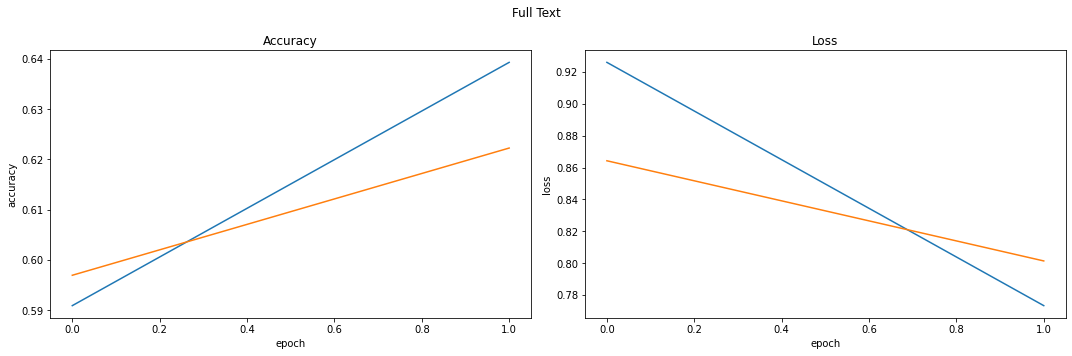

In [136]:
show_results(history, 'Full Text')

##### Tweets 2021 dataset

In [157]:
X_train, y_train, X_test, y_test = retrieve_data('text', data_2021)

Train Set -> (10127, 80) (10127,)
Test Set -> (3376, 80) (3376,)


In [158]:
tweet_2021 = create_model(MAX_WORDS)

start = time()
history = tweet_2021.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.1)
end = time()

#tweet_2021_train_time = end - start

Epoch 1/8
285/285 [==============================] - 58s 178ms/step - loss: 0.7661 - accuracy: 0.6272 - val_loss: 0.5813 - val_accuracy: 0.7660
Epoch 2/8
285/285 [==============================] - 49s 173ms/step - loss: 0.5108 - accuracy: 0.7821 - val_loss: 0.5483 - val_accuracy: 0.7611
Epoch 3/8
285/285 [==============================] - 49s 174ms/step - loss: 0.4669 - accuracy: 0.7993 - val_loss: 0.5025 - val_accuracy: 0.7779
Epoch 4/8
285/285 [==============================] - 49s 173ms/step - loss: 0.4525 - accuracy: 0.8094 - val_loss: 0.5049 - val_accuracy: 0.7749
Epoch 5/8
285/285 [==============================] - 49s 172ms/step - loss: 0.4402 - accuracy: 0.8095 - val_loss: 0.5202 - val_accuracy: 0.7759
Epoch 6/8
285/285 [==============================] - 48s 169ms/step - loss: 0.4277 - accuracy: 0.8170 - val_loss: 0.5270 - val_accuracy: 0.7897
Epoch 7/8
285/285 [==============================] - 49s 172ms/step - loss: 0.4186 - accuracy: 0.8207 - val_loss: 0.5250 - val_accuracy:

In [193]:
pred = tweet_2021.predict(X_test)

d = []

for p in pred:
    d.append(softmax_pred(p - 1))

pred = pd.DataFrame(d)

tweet_2021_accuracy = accuracy_score(y_test, pred)
acc = score(tweet_2021_accuracy)
acc

0.7808056872037914

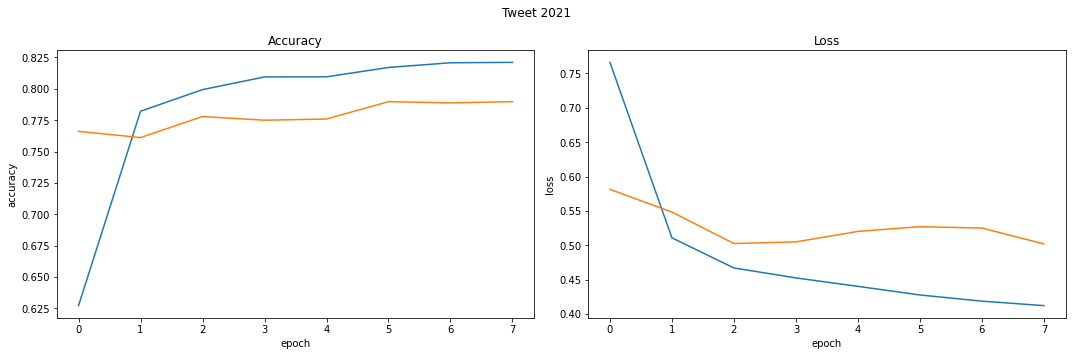

In [195]:
show_results(history, 'Tweet 2021')

---

#### Text metadata

In [198]:
X_train, y_train, X_test, y_test = retrieve_data('text_metadata', data_2022, fix_length=True)

Train Set -> (5927, 80) (5927,)
Test Set -> (1976, 80) (1976,)


In [199]:
text_metadata = create_model(MAX_WORDS)

start = time()
history = text_metadata.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
end = time()

text_metadata_train_time = end - start

Epoch 1/10
167/167 [==============================] - 37s 183ms/step - loss: 0.8241 - accuracy: 0.6235 - val_loss: 0.7054 - val_accuracy: 0.6374
Epoch 2/10
167/167 [==============================] - 30s 179ms/step - loss: 0.6465 - accuracy: 0.6935 - val_loss: 0.6649 - val_accuracy: 0.6459
Epoch 3/10
167/167 [==============================] - 31s 185ms/step - loss: 0.6166 - accuracy: 0.7060 - val_loss: 0.6877 - val_accuracy: 0.6543
Epoch 4/10
167/167 [==============================] - 29s 174ms/step - loss: 0.6003 - accuracy: 0.7117 - val_loss: 0.6604 - val_accuracy: 0.6712
Epoch 5/10
167/167 [==============================] - 29s 174ms/step - loss: 0.5868 - accuracy: 0.7197 - val_loss: 0.6607 - val_accuracy: 0.6610
Epoch 6/10
167/167 [==============================] - 29s 174ms/step - loss: 0.5787 - accuracy: 0.7178 - val_loss: 0.6770 - val_accuracy: 0.6627
Epoch 7/10
167/167 [==============================] - 29s 175ms/step - loss: 0.5746 - accuracy: 0.7195 - val_loss: 0.6813 - val_ac

In [200]:
start = time()
pred = text_metadata.predict(X_test)
end = time()

d = []

for p in pred:
    d.append(softmax_pred(p))

pred = pd.DataFrame(d)

text_metadata_acc = accuracy_score(y_test, pred)
acc = score(text_metadata_acc)


text_metadata_test_time = end - start

In [205]:
print(f"Train time: {text_metadata_train_time}")
print(f"Test time: {text_metadata_test_time}")
print(f"Accuracy: {acc}")

Train time: 305.90561151504517
Test time: 4.907928943634033
Accuracy: 0.7808056872037914


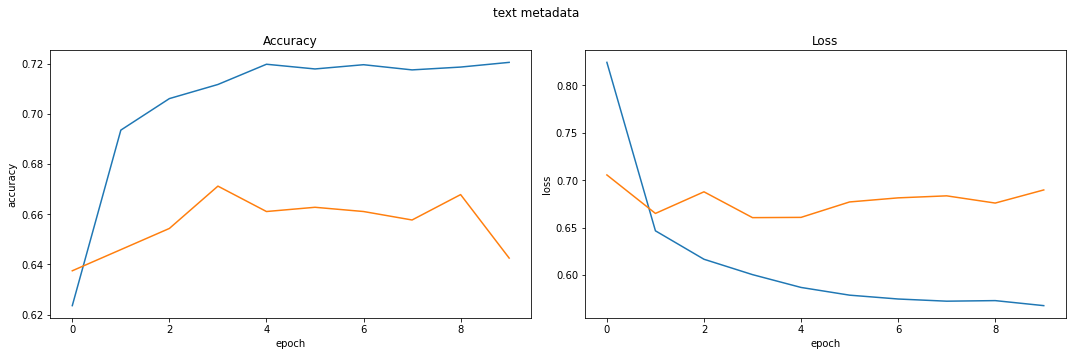

In [202]:
show_results(history, 'text metadata')

---

#### Combined columns

In [206]:
X_train, y_train, X_test, y_test = retrieve_data('combined', data_2022, fix_length=True)

Train Set -> (5927, 80) (5927,)
Test Set -> (1976, 80) (1976,)


In [208]:
combined_model = create_model(MAX_WORDS)
start = time()
history = combined_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
end = time()

combined_time = end - start

167/167 [==============================] - 41s 200ms/step - loss: 0.7716 - accuracy: 0.6505 - val_loss: 0.6660 - val_accuracy: 0.6880
Epoch 2/10
167/167 [==============================] - 32s 192ms/step - loss: 0.5767 - accuracy: 0.7428 - val_loss: 0.6730 - val_accuracy: 0.6914
Epoch 3/10
167/167 [==============================] - 31s 189ms/step - loss: 0.5189 - accuracy: 0.7713 - val_loss: 0.6144 - val_accuracy: 0.7218
Epoch 4/10
167/167 [==============================] - 29s 174ms/step - loss: 0.4894 - accuracy: 0.7917 - val_loss: 0.5839 - val_accuracy: 0.7268
Epoch 5/10
167/167 [==============================] - 30s 178ms/step - loss: 0.4642 - accuracy: 0.8028 - val_loss: 0.6097 - val_accuracy: 0.7133
Epoch 6/10
167/167 [==============================] - 29s 175ms/step - loss: 0.4574 - accuracy: 0.8078 - val_loss: 0.6165 - val_accuracy: 0.7184
Epoch 7/10
167/167 [==============================] - 29s 174ms/step - loss: 0.4458 - accuracy: 0.8151 - val_loss: 0.6601 - val_accuracy: 0.7

In [209]:
start = time()
pred = combined_model.predict(X_test)
end = time()

d = []

for p in pred:
    d.append(softmax_pred(p))

pred = pd.DataFrame(d)

combined_test_time = end - start

combined_acc = accuracy_score(y_test, pred)

In [210]:
print(f"Train time: {combined_time}")
print(f"Test time: {combined_test_time}")


Train time: 304.56558656692505
Test time: 4.700064420700073
accuracy: 0.08451417004048584


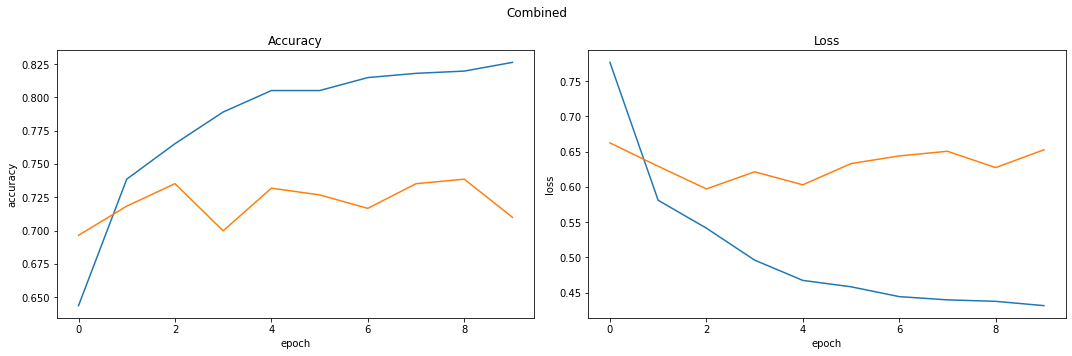

In [211]:
show_results(history, 'Combined')

### Conclusie

Het gebruiken maken van de keras attention library zorgt voor een lagere score dan bij de self attention gemaakt in attention.ipynb